In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [2]:
# correct params
N = 1e6 
M = 2 

beta  = 0.02        # infection rate
gIa   = 1./7        # recovery rate of asymptomatic infectives
gIs   = 1./7        # recovery rate of asymptomatic infectives
gE    = 0.1         # exposed to infected rate
fsa   = 1         # the self-isolation parameter (assumed to be known)
alpha = np.array([0.5, 0.2])       # fraction of asymptomatic infectives

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

def contactMatrix(t):
    return C 

Tf = 300
Nf = Tf+1

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}
true_parameters = parameters

S0 = Ni
Ia0 = np.zeros((M))+1
Ia0[1] += 2
S0[1] -= 2

Is0 = np.zeros((M))
E0 = np.zeros((M))

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data = sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf, method='tau_leaping')

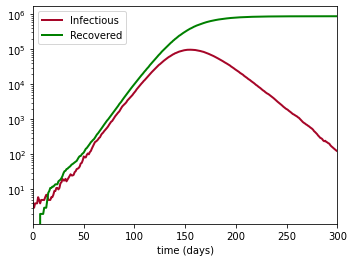

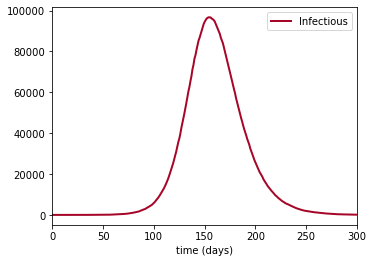

In [3]:
## Plot Results ##

Infectious = np.sum((sto_model.Is(data) + sto_model.Ia(data)), axis=1) 
R = np.sum(sto_model.R(data), axis=1)

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.semilogy(data['t'], Infectious,  color = "#A60628", label = 'Infectious' ,lw = 2)
plt.semilogy(data['t'], R,              color = 'green',   label = 'Recovered'  ,lw = 2)
plt.xlabel('time (days)');       
plt.xlim(0,Tf);  
# plt.ylim(1e-7,2)
plt.legend()
plt.show()

plt.figure(figsize=(12, 4)); plt.subplot(121) 
plt.plot(data['t'], Infectious,  color = "#A60628", label = 'Infectious' ,lw = 2)
plt.xlabel('time (days)');       
plt.xlim(0,Tf);  
# plt.ylim(1e-7,2) 
plt.legend()
plt.show()

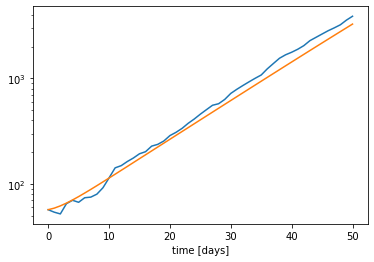

In [4]:
# load the data and rescale to intensive variables 
N_start = 50 # decide based upon when the infected hits ~100 
Tf_inference = 50 
Nf_inference = Tf_inference + 1


x = data['X'].astype('float')
x = x[N_start:N_start+Nf_inference]
steps = 4 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEIR(parameters, M, Ni)


# make a fltr to get N-R and Is for each age class 
fltr=np.kron([[1, 1, 1, 1], [0, 0, 0, 1]], np.identity(M))
obs=np.einsum('ij,kj->ki', fltr, x)
x0=x[0]

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
estimator.set_det_model(parameters)
estimator.set_contact_matrix(contactMatrix)
time_points = np.linspace(0, Tf_inference, Nf_inference)
xm = estimator.integrate(x0, 0, Tf_inference, Nf_inference)

plt.semilogy(np.sum(obs[:, -M:], axis=1))
plt.semilogy(np.sum(np.einsum('ij,kj->ki', fltr, xm)[:, -M:], axis=1))
plt.xlabel("time [days]")
plt.show()

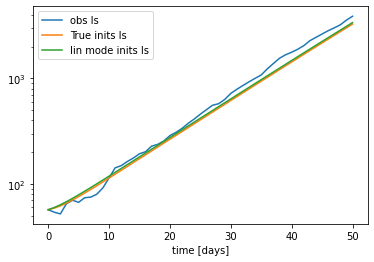

In [5]:
# Set up init priors
init_priors = {} 

# Use lin mode for E 
zero_state = np.zeros((4*M))
zero_state[:M] = Ni 
dev = x0 - zero_state 
c = np.linalg.norm(dev, ord=1) # coefficient of the linear mode 
init_priors['lin_mode_coeff'] = {
        'mean':c, 
        'std':c, 
        'bounds': [1, c*10], 
        'fltr': np.repeat([False, True, False, False], M) # Infer E with lin modes
    }

# But guess Ia0 independently 
eps = 1e-3 
init_priors['independent'] = {
    'mean': x0[4:6], # in practice, would use the lin mode as initial guess 
    'std': x0[4:6]/2, 
    'bounds': [[eps, 1e4] for i in range(M)], 
    'fltr': np.repeat([False, False, True, False], M) # Infer Ia with this 
} 

x0_approx = estimator.get_mean_inits(init_priors, obs[0], fltr)
xm_approx = estimator.integrate(x0_approx, 0, Tf_inference, Nf_inference)

plt.semilogy(np.sum(obs[:, -2:], axis=1), label='obs Is')
plt.semilogy(np.sum(np.einsum('ij,kj->ki', fltr, xm)[:, -2:], axis=1), label='True inits Is')
plt.semilogy(np.sum(np.einsum('ij,kj->ki', fltr, xm_approx)[:, -2:], axis=1), label='lin mode inits Is')
plt.legend()
plt.xlabel("time [days]")
plt.show()

In [6]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa,'gIs':gIs, 'gE':gE, 'fsa':fsa}

estimator.set_lyapunov_method('euler')
logp = estimator.minus_logp_red(parameters, x0_approx, obs, fltr, Tf_inference, contactMatrix, tangent=True)
end_time = time.time()
print(logp) 
print(end_time - start_time)

759.6197749830571
0.03530621528625488


In [7]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-3
param_priors = {
    'alpha':{
        'mean': [0.5, 0.2], 
        'infer_scale': True, 
        'scale_factor_std': 1,
        'scale_factor_bounds': [eps, 10]
    }, 
    'beta':{
        'mean': 0.03, 
        'std': 0.02, 
        'bounds': [eps, 1]
    }, 
    'gE':{
        'mean': 0.11, 
        'std': 0.05, 
        'bounds': [eps, 0.2]
    }
}


# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

start_time = time.time()
res = estimator.latent_infer_parameters(obs, fltr, Tf_inference, contactMatrix, param_priors, init_priors, 
                                           tangent=True, verbose=True, enable_global=True, 
                                           cma_population=32, global_max_iter=100, global_atol=10, 
                                           local_max_iter=200, ftol=ftol)
end_time = time.time()
print(end_time - start_time)
print(res)

Starting global minimisation...
(16_w,32)-aCMA-ES (mu_w=9.2,w_1=19%) in dimension 6 (seed=2259418224, Sun Jun 28 12:34:16 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     32 8.457355848402320e+02 1.0e+00 9.33e-01  2e-02  5e+02 0:00.4
    2     64 7.897638741768047e+02 1.3e+00 8.46e-01  1e-02  5e+02 0:00.8
    3     96 8.645210792242428e+02 1.7e+00 9.45e-01  1e-02  5e+02 0:01.0
   16    512 7.609965909412196e+02 7.6e+00 3.10e-01  2e-03  1e+02 0:04.2
   26    832 7.554619357021145e+02 2.4e+01 2.50e-01  2e-03  6e+01 0:06.5
Optimal value (global minimisation):  755.1721273865606
Starting local minimisation...
Optimal value (local minimisation):  755.0096142078988
7.387833118438721
{'map_params_dict': {'alpha': array([0.49184497, 0.19673799]), 'beta': 0.020626426149818772, 'gIa': array([0.14285714, 0.14285714]), 'gIs': array([0.14285714, 0.14285714]), 'gE': 0.10133809016239555, 'fsa': array([1., 1.])}, 'map_x0': array([2.49820832e+05, 7.49806443e+05, 8

In [8]:
# print the correct params and best estimates 
print('True parameters')
print(parameters)

best_estimates = res['map_params_dict']
print('\n Best estimates')
print(res['map_params_dict'])

print('\n True initial conditions: ') 
print((x[0]).astype('int'))


map_x0 = res['map_x0']
print('\n Inferred initial conditons: ') 
print(map_x0.astype('int'))

logp = estimator.minus_logp_red(best_estimates, map_x0, obs, fltr, Tf_inference, contactMatrix, tangent=True)

print('\n log p for best estimates:')
print(logp)

True parameters
{'alpha': array([0.5, 0.2]), 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'gE': 0.1, 'fsa': 1}

 Best estimates
{'alpha': array([0.49184497, 0.19673799]), 'beta': 0.020626426149818772, 'gIa': array([0.14285714, 0.14285714]), 'gIs': array([0.14285714, 0.14285714]), 'gE': 0.10133809016239555, 'fsa': array([1., 1.])}

 True initial conditions: 
[249831 749819     77     71     23      7     20     37]

 Inferred initial conditons: 
[249820 749806     85     85     24      5     20     37]

 log p for best estimates:
747.223840178711


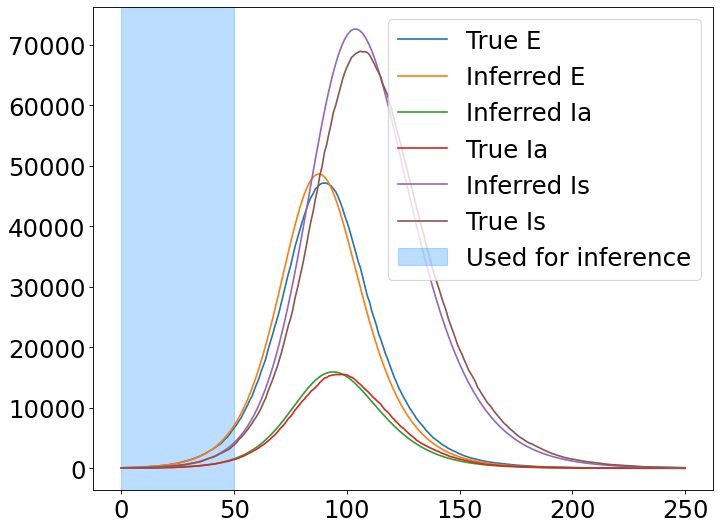

In [9]:
# plot the guessed trajectory and the true trajectory
estimator.set_params(best_estimates)
estimator.set_det_model(best_estimates)
x_det = estimator.integrate(map_x0, 0, Tf-N_start, Nf-N_start, method='LSODA')
x = data['X'][N_start:]
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(x[:,M], label='True E')
plt.plot(x_det[:, M], label='Inferred E')
plt.plot(x_det[:, 2*M], label='Inferred Ia')
plt.plot(x[:,2*M], label='True Ia')
plt.plot(np.sum(x_det[:, 3*M:], axis=1), label='Inferred Is')
plt.plot(np.sum(x[:,3*M:], axis=1), label='True Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show()

# Under construction from here onwards

In [90]:
# Calculate hessian 
eps = 1e-3*params
print(eps)
hess = estimator.hessian_lin_mode(param_keys, params, guess, stds,
                                    obs, fltr, Tf_inference, Nf_inference, contactMatrix, 
                                    tangent=True,
                                    infer_scale_parameter=False,
                                    eps=eps, fd_method='central')
cov = np.linalg.inv(hess)
v, w = np.linalg.eig(cov)
print(v)

[2.42208329e-05 1.63437933e-04 1.39081526e-04 7.17049874e-05
 5.51110090e-01]
[2.25265924e+04 4.24421790e-04 9.81040289e-06 6.71572276e-08
 3.74508207e-06]


In [91]:
n_samples = 500

sample_parameters = np.random.multivariate_normal(params, cov, n_samples)
trajectories = np.empty((n_samples, Nf-N_start, estimator.dim))

for i in range(n_samples):
    print('Running simulation {0} of {1}'.format(i+1,n_samples),end='\r')
    while (sample_parameters[i] < 0).any():
        sample_parameters[i] = np.random.multivariate_normal(params, cov)
    
    parameters = estimator.fill_params_dict(param_keys, sample_parameters[i])
    estimator.set_params(parameters)
    x0_inf = estimator.lin_mode_inits(sample_parameters[i, -1], contactMatrix)

    det_model = estimator.make_det_model(parameters)
    trajectories[i] = estimator.integrate(x0_inf, 0, Tf-N_start, Nf-N_start, det_model, contactMatrix)

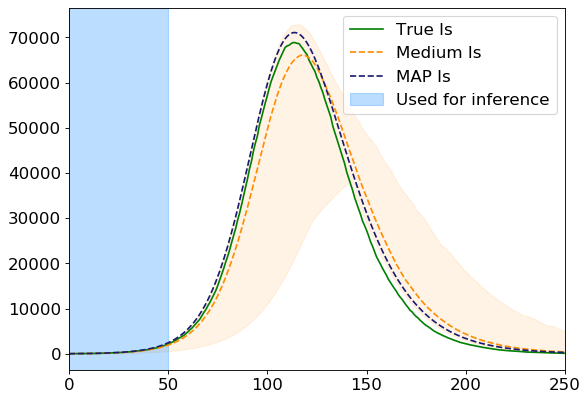

In [92]:
x = data['X'][N_start:]/A
lower = np.percentile(trajectories, 10, axis=0)
upper = np.percentile(trajectories, 90, axis=0)
medium = np.percentile(trajectories, 50, axis=0)

Is_lower = np.sum(lower[:, 3*M:], axis=1)
Is_upper = np.sum(upper[:, 3*M:], axis=1)
Is_medium = np.sum(medium[:, 3*M:], axis=1)

estimator.set_params(best_estimates)
x0_inf = estimator.lin_mode_inits(params[-1], contactMatrix)
det_model = estimator.make_det_model(best_estimates)
x_map = estimator.integrate(x0_inf, 0, Tf-N_start, Nf-N_start, det_model, contactMatrix)
Is_map = np.sum(x_map[:, 3*M:], axis=1)

t = np.arange(lower.shape[0])
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 15})
plt.fill_between(t, Is_lower, Is_upper, color='darkorange', alpha='0.1')
plt.plot(np.sum(x[:, 3*M:], axis=1), color='green', label='True Is')
plt.plot(Is_medium, '--', color='darkorange', label='Medium Is')
plt.plot(Is_map, '--', color='midnightblue', label='MAP Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend(loc='upper right')
plt.xlim([0, t[-1]])
plt.show() 